In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_columns", None)

from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.linear_model import LinearRegression,Lasso,RidgeCV
from sklearn.tree import DecisionTreeRegressor,plot_tree
from sklearn.ensemble import RandomForestRegressor,StackingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error,r2_score


#设置中文字体
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  
matplotlib.rcParams['axes.unicode_minus']=False  #正常显示负号

from plotnine import *
import plotnine
plotnine.options.base_family='SimHei'
from warnings import filterwarnings
#过滤警告信息
filterwarnings("ignore")

In [2]:
#读取数据
raw_data=pd.read_excel('raw_data.xlsx',index_col=0)
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 405 entries, 1 to 405
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   电池类型         405 non-null    object 
 1   PN结位置        405 non-null    object 
 2   IBC          405 non-null    object 
 3   双面           405 non-null    object 
 4   c-Si厚度       405 non-null    object 
 5   c-Si电阻率      405 non-null    object 
 6   c-Si晶相       405 non-null    object 
 7   c-Si提拉方式     405 non-null    object 
 8   材料           405 non-null    object 
 9   制备方式         405 non-null    object 
 10  厚度           405 non-null    object 
 11  poly-Si沉积方式  405 non-null    object 
 12  poly-Si厚度    405 non-null    object 
 13  poly-Si掺杂方式  405 non-null    object 
 14  额外掺杂         405 non-null    object 
 15  晶化温度         405 non-null    object 
 16  氢化方式         405 non-null    object 
 17  VOC          405 non-null    object 
 18  JSC          405 non-null    object 
 19  FF      

# 数据清洗

In [3]:
df=raw_data.copy()

#c-Si厚度
df['c-Si厚度']=np.where(df['c-Si厚度']=='—',np.nan,df['c-Si厚度'])
df['c-Si厚度']=df['c-Si厚度'].astype(float)

#c-Si电阻率
df['c-Si电阻率']=np.where(df['c-Si电阻率']=='—',np.nan,df['c-Si电阻率'])
df['c-Si电阻率']=df['c-Si电阻率'].astype(float)

#厚度
df['厚度']=np.where(df['厚度']=='—',np.nan,df['厚度'])
df['厚度']=df['厚度'].astype(float)

#poly-Si厚度
df['poly-Si厚度']=np.where(df['poly-Si厚度']=='—',np.nan,df['poly-Si厚度'])
df['poly-Si厚度']=df['poly-Si厚度'].astype(float)

#晶化温度
df['晶化温度']=np.where(df['晶化温度']=='—',np.nan,df['晶化温度'])
df['晶化温度']=df['晶化温度'].astype(float)

#VOC
df['VOC']=np.where(df['VOC']=='—',np.nan,df['VOC'])
df['VOC']=df['VOC'].astype(float)
#JSC
df['JSC']=np.where(df['JSC']=='—',np.nan,df['JSC'])
df['JSC']=df['JSC'].astype(float)
#FF
df['FF']=np.where(df['FF']=='—',np.nan,df['FF'])
df['FF']=df['FF'].astype(float)

df_na=df.copy()
#用平均值填充缺失值
df['c-Si厚度']=df['c-Si厚度'].fillna(df['c-Si厚度'].mean())
df['c-Si电阻率']=df['c-Si电阻率'].fillna(df['c-Si电阻率'].mean())
df['厚度']=df['厚度'].fillna(df['厚度'].mean())
df['poly-Si厚度']=df['poly-Si厚度'].fillna(df['poly-Si厚度'].mean())
df['晶化温度']=df['晶化温度'].fillna(df['晶化温度'].mean())

df['c-Si晶相']=df['c-Si晶相'].astype(str)
#删除因变量带有缺失值的样本
df=df.dropna(subset=['VOC','JSC','FF'])
#删除效率低于20的样本
df=df[df['Efficiency']>20]

# 特征工程

In [4]:
from sklearn.preprocessing import StandardScaler

X=df.drop(columns=['VOC','JSC','FF','Efficiency']).copy()
#对数值变量进行z-score标准化
num_cols=['c-Si厚度','c-Si电阻率','厚度','poly-Si厚度','晶化温度']
X[num_cols]=StandardScaler().fit_transform(X[num_cols])

#对类别变量进行one-hot编码
X=pd.get_dummies(X,drop_first=True)
y1=df['VOC']
y2=df['JSC']
y3=df['FF']
y4=df['Efficiency']
#['VOC', 'JSC', 'FF', 'Efficiency']

In [5]:
X.head()

,c-Si厚度,c-Si电阻率,厚度,poly-Si厚度,晶化温度,电池类型_n-mc-Si,电池类型_p,PN结位置_背,IBC_是,双面_是,c-Si晶相_—,c-Si提拉方式_FZ,c-Si提拉方式_—,材料_SiOx,材料_—,制备方式_H2O2,制备方式_H2O2/H2SO4,制备方式_HNO3,制备方式_HNO3/H2SO4,制备方式_N2O,制备方式_O3,制备方式_PECVD,制备方式_plasma,制备方式_thermal,制备方式_—,poly-Si沉积方式_LPCVD,poly-Si沉积方式_PECVD,poly-Si沉积方式_Sputtering,poly-Si沉积方式_—,poly-Si掺杂方式_in-situ,poly-Si掺杂方式_ion-implantation,poly-Si掺杂方式_—,额外掺杂_N,额外掺杂_O,额外掺杂_—,额外掺杂_无,氢化方式_H-rich layers,氢化方式_H2O,氢化方式_RPHP,氢化方式_—
1,0.109323,-0.248646,-0.449242,-1.246277,-1.190842,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0
4,0.109323,-0.248646,-0.449242,-1.246277,-1.190842,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0
5,0.109323,-0.248646,-0.449242,-1.246277,-1.190842,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0
9,0.199398,0.025614,-1.386918,-1.107384,-1.190842,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0
10,-0.021814,-0.282929,-0.449242,-1.304149,-1.190842,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0


In [1]:
#训练集和测试集划分,训练集75%,测试集25%
X_train1,X_test1,y_train1,y_test1=train_test_split(X,y1,test_size=0.25,random_state=1)
X_train2,X_test2,y_train2,y_test2=train_test_split(X,y2,test_size=0.25,random_state=1)
X_train3,X_test3,y_train3,y_test3=train_test_split(X,y3,test_size=0.25,random_state=1)
X_train4,X_test4,y_train4,y_test4=train_test_split(X,y4,test_size=0.25,random_state=1)

NameError: name 'train_test_split' is not defined

In [8]:
X_test1.shape

(76, 40)

# 建模

In [9]:
#定义一个模型训练和预测函数
def train_predict(X_train=X_train1,X_test=X_test1,y_train=y_train1,y_test=y_test1,
                  response_variable='VOC',
                  base_estimators=['lasso','rf','bp']):    

    ###Lasso线性回归
    print('----------------------------Lasso线性回归-----------------------------------')
    lasso=Lasso()
    #定义参数区间
    param1={'alpha':[1e-3,1e-2,1e-1,1,1e1,1e2,1e3]}

    # 5折交叉验证寻找最佳参数
    reg1=GridSearchCV(lasso,param1,cv=5,n_jobs=-1,scoring='neg_root_mean_squared_error')
    reg1.fit(X_train,y_train)

    #最佳参数
    print(reg1.best_params_)
    #rmse
    print(-reg1.best_score_)


    ###随机森林回归
    print('-----------------------------随机森林回归-----------------------------------')
    #定义参数区间
    param2={'n_estimators':range(100,600,50),
           'max_depth':range(5,15)}
    rf=RandomForestRegressor(random_state=0)
    # 5折交叉验证寻找最佳参数
    reg2=GridSearchCV(rf,param2,cv=5,n_jobs=-1,scoring='neg_root_mean_squared_error')
    reg2.fit(X_train,y_train)

    #最佳参数
    print(reg2.best_params_)
    #rmse
    print(-reg2.best_score_)


    #输出特征重要性
    print('---------------输出特征重要性-----------------')
    feature_importance=pd.Series(reg2.best_estimator_.feature_importances_,index=X_train.columns)
    #对特征重要性进行排序
    importance=feature_importance.sort_values(ascending=False)
    print(importance)
    #重要性柱状图
    print(importance[:10].plot.barh())

    ###人工神经网络
    print('-----------------------------人工神经网络-----------------------------------')
    param3={'hidden_layer_sizes':[(50,),(100),(50,50),(100,100)],
            'alpha':[1e-01, 1e-02, 1e-03, 1e-04, 1e-05, 1e-06]}
    mlp=MLPRegressor(random_state=1,max_iter=1000)
    # 5折交叉验证寻找最佳参数
    reg3=GridSearchCV(mlp,param3,cv=5,n_jobs=-1,scoring='neg_root_mean_squared_error')
    reg3.fit(X_train,y_train)

    #最佳参数
    print(reg3.best_params_)
    #rmse
    print(-reg3.best_score_)

    ###Stacking 
    estimators_all= {'lasso':('lasso',reg1),
                'rf':('rf',reg2),
                'bp':('bp',reg3)}
    
    reg4=StackingRegressor(estimators=[estimators_all[m] for m in base_estimators],
                           final_estimator=RidgeCV())
    reg4.fit(X_train,y_train)
    #模型性能比较
    print('-----------------------------模型性能比较-----------------------------------')
    models=[reg1,reg2,reg3,reg4]
    #r2 socre
    r2=[]
    #mae
    mae=[]
    #rmse
    rmse=[]
    #mape
    mape=[]

    for model in models:
        pred_test=model.predict(X_test)    
        r2.append(r2_score(y_test,pred_test))
        mae.append(mean_absolute_error(y_test,pred_test))
        rmse.append(mean_squared_error(y_test,pred_test,squared=False))
        mape.append(mean_absolute_percentage_error(y_test,pred_test))





    #将结果组合为数据框
    compare=pd.DataFrame({'r2':r2,
                         'mae':mae,
                         'rmse':rmse,
                         'mape':mape},index=['lasso','rf','bp','stacking'])
    print(compare)

    #输出真实值和预测值的对比
    df_compare=X_test.copy()
    df_compare[response_variable]=y_test
    df_compare[response_variable+'_lasso_pred']=reg1.predict(X_test)
    df_compare[response_variable+'_rf_pred']=reg2.predict(X_test)
    df_compare[response_variable+'_ann_pred']=reg3.predict(X_test)
    df_compare[response_variable+'_stacking_pred']=reg4.predict(X_test)
    df_compare.to_excel("df_compare_{}.xlsx".format(response_variable))
    
    

# VOC

----------------------------Lasso线性回归-----------------------------------
{'alpha': 1}
17.13116856830718
-----------------------------随机森林回归-----------------------------------
{'max_depth': 14, 'n_estimators': 300}
13.35901005081539
---------------输出特征重要性-----------------
c-Si电阻率                         0.223843
poly-Si厚度                       0.176740
c-Si厚度                          0.097407
晶化温度                            0.084650
厚度                              0.063031
电池类型_p                          0.054216
c-Si提拉方式_FZ                     0.041889
c-Si晶相_—                        0.024308
PN结位置_背                         0.022045
制备方式_O3                         0.018895
IBC_是                           0.015237
氢化方式_RPHP                       0.015076
poly-Si沉积方式_PECVD               0.014846
c-Si提拉方式_—                      0.014235
双面_是                            0.012295
制备方式_thermal                    0.010783
poly-Si掺杂方式_in-situ             0.010687
poly-Si沉积方式_—                  

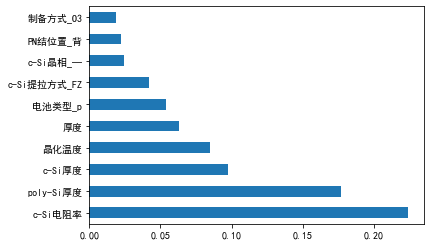

In [10]:
#VOC
train_predict(X_train=X_train1,X_test=X_test1,y_train=y_train1,y_test=y_test1,response_variable='VOC')

# JSC

----------------------------Lasso线性回归-----------------------------------
{'alpha': 0.01}
1.1722638331858422
-----------------------------随机森林回归-----------------------------------
{'max_depth': 14, 'n_estimators': 300}
0.9458235209977882
---------------输出特征重要性-----------------
poly-Si厚度                       0.173747
双面_是                            0.155864
c-Si厚度                          0.120362
c-Si电阻率                         0.097581
晶化温度                            0.084608
厚度                              0.053256
氢化方式_RPHP                       0.046522
PN结位置_背                         0.037268
poly-Si沉积方式_PECVD               0.025920
c-Si提拉方式_FZ                     0.024273
电池类型_p                          0.018298
制备方式_O3                         0.018048
氢化方式_H-rich layers              0.016531
poly-Si沉积方式_LPCVD               0.015011
c-Si晶相_—                        0.014787
poly-Si掺杂方式_ion-implantation    0.014574
额外掺杂_无                          0.012340
IBC_是                     

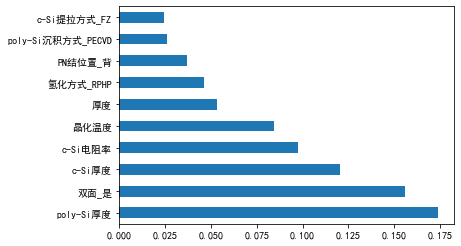

In [12]:
#JSC
train_predict(X_train=X_train2,X_test=X_test2,y_train=y_train2,y_test=y_test2,response_variable='JSC')

# FF

----------------------------Lasso线性回归-----------------------------------
{'alpha': 10.0}
3.917864389019067
-----------------------------随机森林回归-----------------------------------
{'max_depth': 11, 'n_estimators': 100}
3.9259850849210998
---------------输出特征重要性-----------------
c-Si厚度                          0.133846
厚度                              0.125160
晶化温度                            0.118332
poly-Si厚度                       0.116288
c-Si电阻率                         0.079008
氢化方式_RPHP                       0.073925
材料_SiOx                         0.066651
c-Si晶相_—                        0.047334
双面_是                            0.043368
poly-Si掺杂方式_in-situ             0.026656
c-Si提拉方式_FZ                     0.022603
氢化方式_H-rich layers              0.020284
c-Si提拉方式_—                      0.018307
poly-Si沉积方式_PECVD               0.014324
制备方式_thermal                    0.013844
poly-Si掺杂方式_ion-implantation    0.011852
额外掺杂_无                          0.009911
额外掺杂_O                     

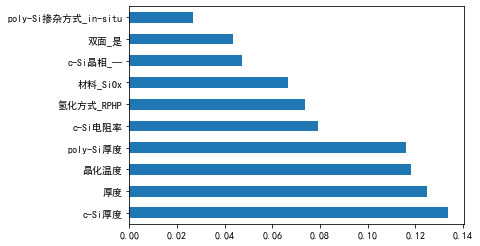

In [13]:
#FF
train_predict(X_train=X_train3,X_test=X_test3,y_train=y_train3,y_test=y_test3,response_variable='FF')

# Efficiency

----------------------------Lasso线性回归-----------------------------------
{'alpha': 0.01}
1.1854122053119345
-----------------------------随机森林回归-----------------------------------
{'max_depth': 13, 'n_estimators': 450}
0.8948024438288495
---------------输出特征重要性-----------------
c-Si电阻率                         0.244186
c-Si厚度                          0.210168
poly-Si厚度                       0.147127
晶化温度                            0.078495
厚度                              0.042381
氢化方式_RPHP                       0.031535
poly-Si沉积方式_PECVD               0.022235
PN结位置_背                         0.022117
c-Si晶相_—                        0.021605
额外掺杂_无                          0.019579
IBC_是                           0.019519
c-Si提拉方式_—                      0.013012
c-Si提拉方式_FZ                     0.012938
poly-Si沉积方式_—                   0.009856
poly-Si沉积方式_LPCVD               0.009806
制备方式_thermal                    0.009613
制备方式_HNO3                       0.009503
双面_是                      

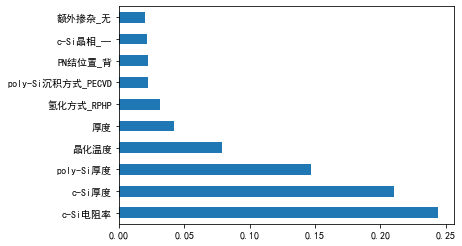

In [14]:
#Efficiency
train_predict(X_train=X_train4,X_test=X_test4,y_train=y_train4,y_test=y_test4,response_variable='Efficiency')

In [7]:
X_train1.shape

(228, 40)

# 决策树

In [65]:
def dt_plot(X=X,y=y1):
    #定义参数区间
    param={'max_depth':range(2,20)}
    dt=DecisionTreeRegressor(random_state=0)
    #5折交叉验证寻找最佳参数
    reg=GridSearchCV(dt,param,cv=5,n_jobs=-1,scoring='neg_root_mean_squared_error')
    reg.fit(X,y)

    #plot_tree决策树可视化
    fig,ax=plt.subplots(1,1,figsize=[24,14])
    _=plot_tree(reg.best_estimator_,          
              fontsize=12,
              ax=ax,
              feature_names=X.columns,
              filled=True,
              impurity=True,
             rounded=True)

In [ ]:
#['VOC', 'JSC', 'FF', 'Efficiency']

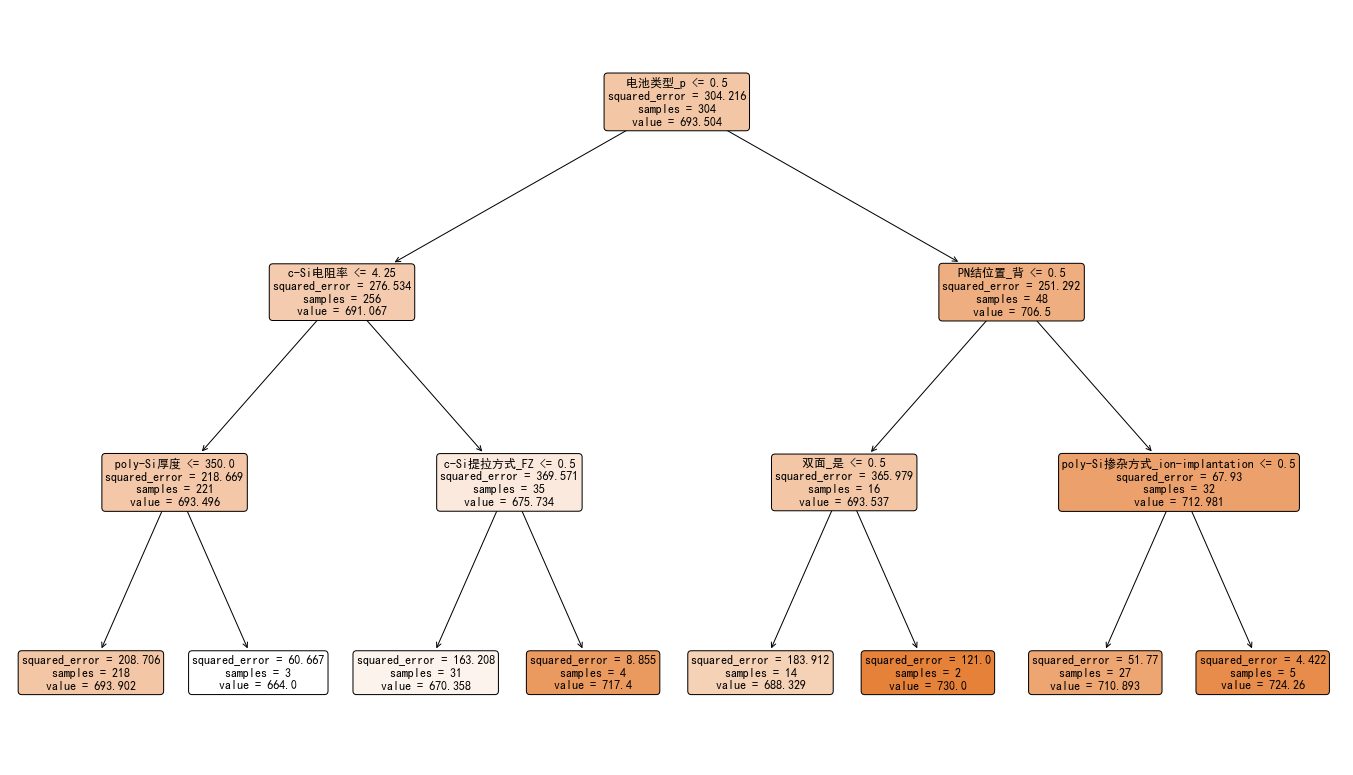

In [66]:
#VOC
dt_plot(X,y1)

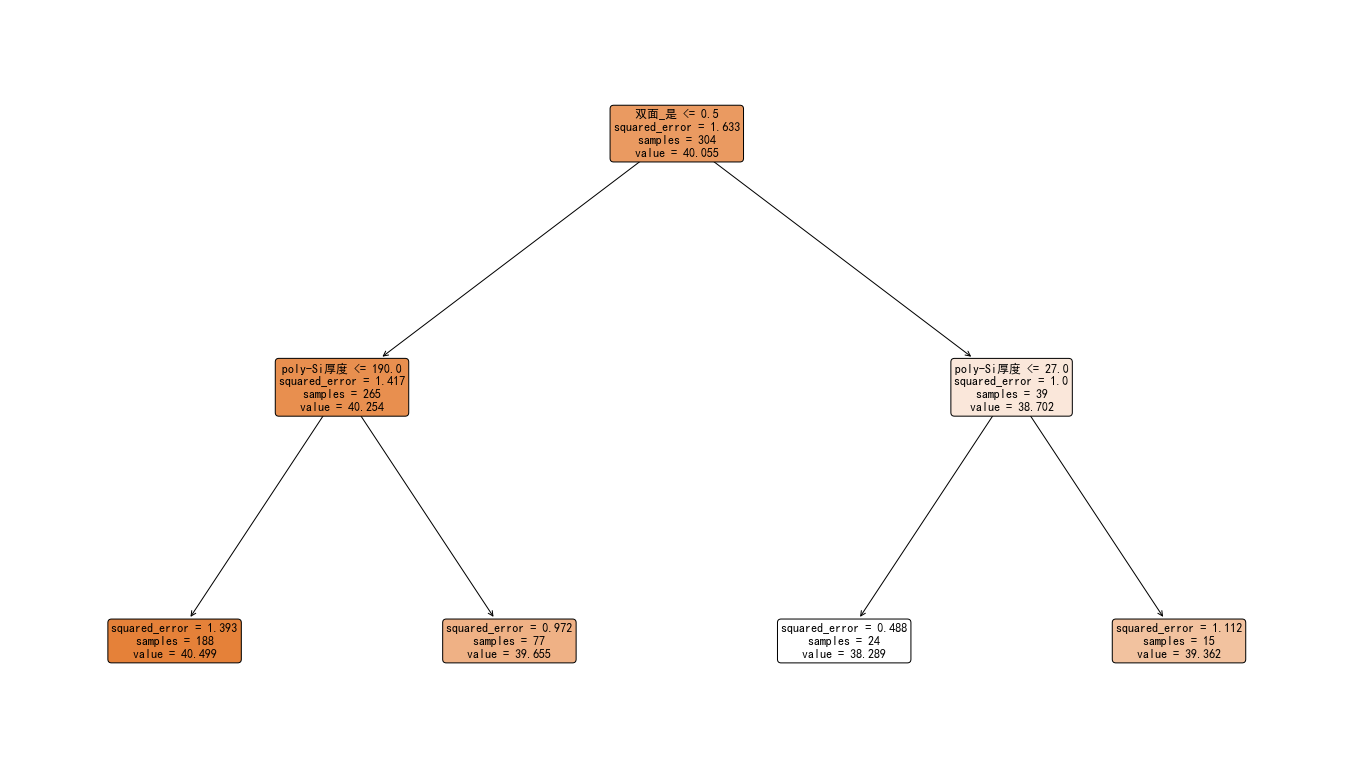

In [67]:
#JSC
dt_plot(X,y2)

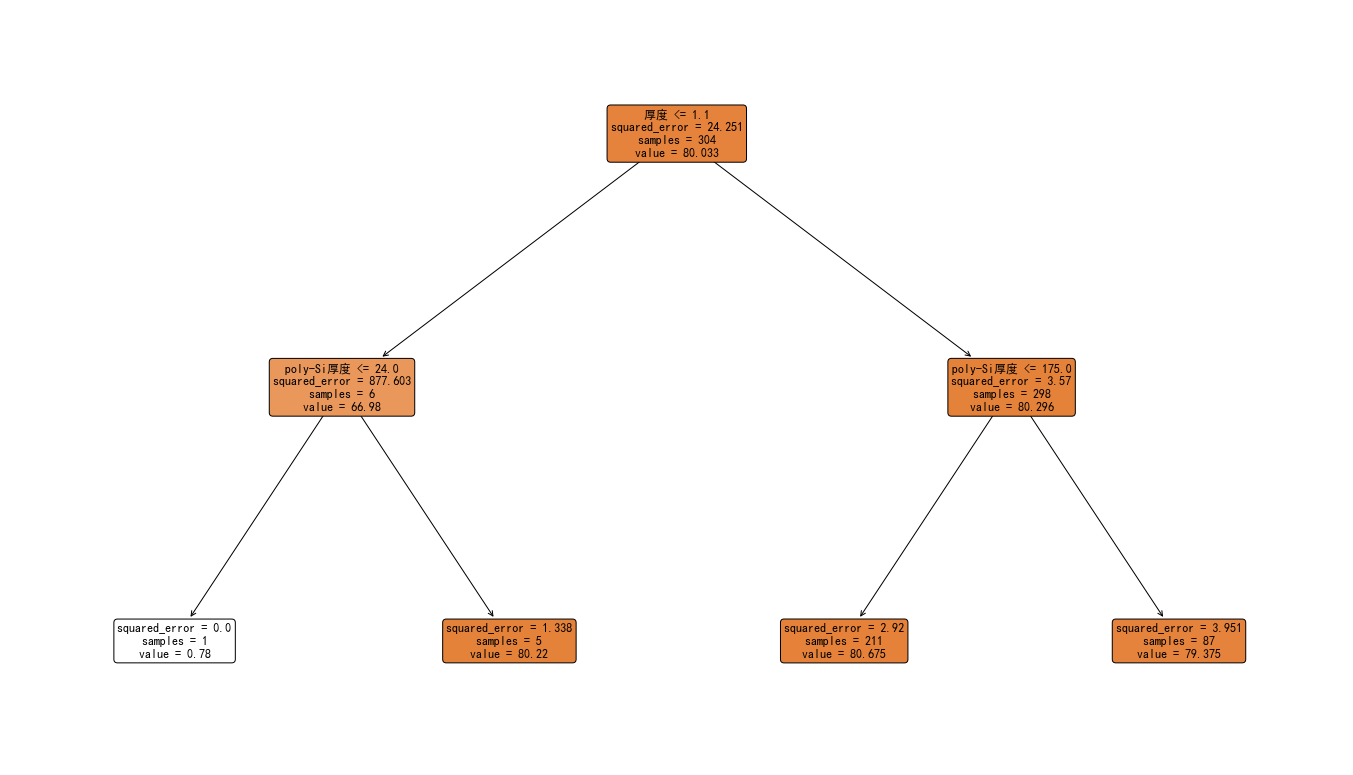

In [68]:
#FF
dt_plot(X,y3)

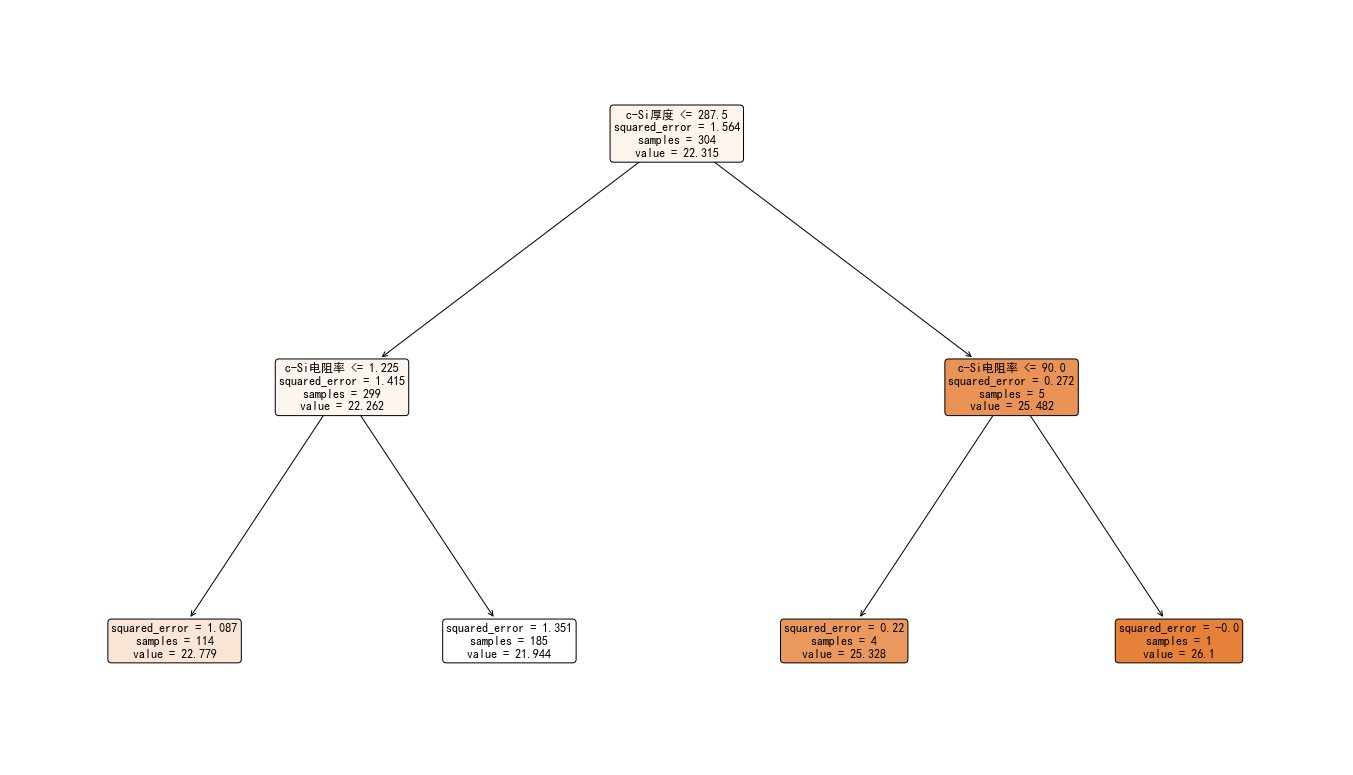

In [69]:
#Efficiency
dt_plot(X,y4)

对于Efficiency的决策树看出，当c-Si厚度>287.5 & c-Si电阻率>90时，电池效率最高，为26.1.
同时从上面的决策树可以看出c-Si厚度>287.5时，电池效率平均为25.482,c-Si厚度>287.5时的电池效率平均仅为22.262.